In [1]:
import numpy as np

from scipy import linalg as la
from scipy.optimize import minimize

from matplotlib import pyplot as plt

from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.aqua.operators import MatrixOp

from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance

## Define Matrix and compute its eigenvalues and eigenvectors

In [2]:
M = np.array([[1,  0,  0, 0], 
              [0,  0, -1, 0], 
              [0, -1,  0, 0], 
              [0,  0,  0, 1]])
eigvals, eigvecs = la.eig(M)
# The eigenvalues of A are
print("Eigenvalues: ", eigvals.real)
# The eigenvectors of A are
print("Eigenvectors: ", eigvecs)

Eigenvalues:  [ 1. -1.  1.  1.]
Eigenvectors:  [[ 0.          0.          1.          0.        ]
 [-0.70710678  0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.          1.        ]]


### NOTE: Our lowest eigenvalue is -1

## Process
### 1. Decompose M into sum of Pauli terms

Decomposition involves only terms consisting of the same matrices, i.e.: II, XX, YY, ZZ, and the coefficients are from the set [-1/2, -1, 0, 1, 1/2].


In [3]:
H = MatrixOp(M).to_pauli_op()
print(H)

SummedOp(
[0.5 * II,
-0.5 * XX,
-0.5 * YY,
0.5 * ZZ])


### 2. Choose ansatz

The ansatz you can use is: (RX I) CX (HI) |00>, where angle in RX is your variational parameter.

In [4]:
def ansatz():
    """
    Creates ansatz and returns a quantum circuit.
    :return: quantum circuit
    """
    phi = Parameter('φ')
    qc = QuantumCircuit(2)
    qc.h([0])
    qc.cx([0], [1])
    qc.rx(phi, [0])
    
    return qc, phi

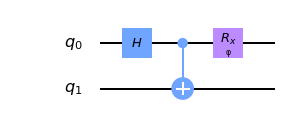

In [5]:
qc, param = ansatz()
qc.draw()

### 3. VQE implementation
#### 3.1

In [6]:
backend = Aer.get_backend('qasm_simulator')

In [7]:
def measure(circuit):
    """
    Takes the quantum circuit and performs measurements and returns the expectation value
    :param circuit: Quantum circuit
    :return: expectation value
    """
    result = execute(circuit, backend=backend, shots=1024).result()
    counts = result.get_counts()
    
    expectation = 0.0
    for key in ['00', '11']:
        expectation += counts.get(key, 0.0)
    for key in ['01', '10']:
        expectation -= counts.get(key, 0.0)
    return expectation / 1024

In [8]:
# XX expectation
def XX(phi):
    """
    Gives the expectation value of XX sub hamiltonian from measurement
    on parametric state
    :param phi: angle in radians
    :return: expectation value of XX 
    """
    circ = qc.bind_parameters({param: phi[0]})
    # circ.h(qr[0])
    # circ.h(qr[1])
    circ.ry(-np.pi/2, 0)
    circ.ry(-np.pi/2, 1)
    circ.measure_all()
    
    expectation = measure(circ)
    return expectation

In [9]:
# YY expectation
def YY(phi):
    """
    Gives the expectation value of YY sub hamiltonian from measurement
    on parametric state
    :param phi: angle in radians
    :return: expectation value of YY 
    """
    circ = qc.bind_parameters({param: phi[0]})
#     circ.sdg(qr[0])
#     circ.h(qr[0])
#     circ.sdg(qr[1])
#     circ.h(qr[1])
    circ.rx(np.pi/2, 0)
    circ.rx(np.pi/2, 1)
    circ.measure_all()
    
    expectation = measure(circ)
    return expectation

In [10]:
# ZZ expectation
def ZZ(phi):
    """
    Gives the expectation value of ZZ sub hamiltonian from measurement
    on parametric state
    :param phi: angle in radians
    :return: expectation value of ZZ 
    """
    circ = qc.bind_parameters({param: phi[0]})
    circ.measure_all()
    
    expectation = measure(circ)
    return expectation

In [11]:
def cost(phi):
    return 0.5 + (-0.5 * XX(phi)) + (- 0.5 * YY(phi)) + (0.5 * ZZ(phi))

In [12]:
phi = np.random.uniform(0, 2 * np.pi)

print('Lowest eigenvalue: ', cost(phi=[phi]))

Lowest eigenvalue:  -0.5009765625


In [13]:
eigenvalues = []
angles = np.linspace(0,2*np.pi,250)
for phi in angles:
    eigenvalues.append(cost(phi=[phi]))

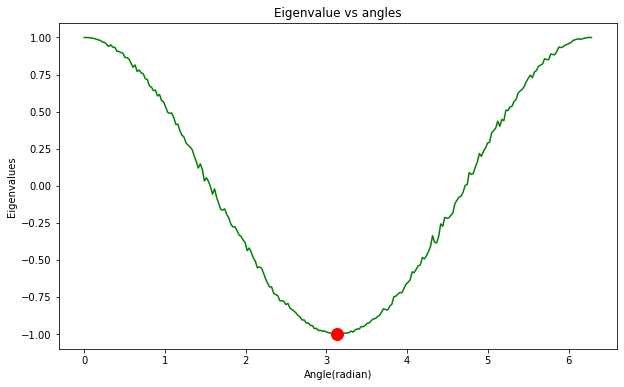

In [14]:
plt.figure(figsize=(10,6))
plt.plot(angles, eigenvalues, 'g')
plt.plot(angles[eigenvalues.index(-1.0)], min(eigenvalues), "ro", markersize=12)
plt.title("Eigenvalue vs angles")
plt.xlabel("Angle(radian)")
plt.ylabel("Eigenvalues")
plt.show()

### 3.3 Using `scipy` minimize function

In [15]:
# random initial choice
phi = np.random.uniform(0, 2 * np.pi)

res = minimize(cost, phi, method='COBYLA')

print('Lowest eigenvalue: ', res.fun)
res

Lowest eigenvalue:  -1.0


     fun: -1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 17
  status: 1
 success: True
       x: array(9.40225711)

### 4. VQE in Qiskit

We use an already built VQE instance in Qisit Aqua

In [16]:
optimizer = SPSA()

var_form, _ = ansatz()
vqe = VQE(operator=H, var_form=var_form, optimizer=optimizer)
vqe_results = vqe.run(QuantumInstance(backend=Aer.get_backend('qasm_simulator')))

print("Lowest eigenvalue: ", vqe_results.eigenvalue)

Lowest eigenvalue:  (-1+0j)
